<a href="https://colab.research.google.com/github/MuaazZakria/Muaaz-Zakria/blob/master/MSDS19053_A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TASK 1

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [3]:
from google.colab import drive
drive.mount("./gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./gdrive


In [5]:
!unzip "./gdrive/My Drive/Copy of Assignment 5 Dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Assignment 5 Dataset/train/normal/7ec0b033-9133-4f8c-abd0-ea246aa21dfa.png  
  inflating: Assignment 5 Dataset/train/normal/7ec4666c-0304-4b7b-8263-bf417ab7cccd.png  
  inflating: Assignment 5 Dataset/train/normal/7ee9ace4-3059-49c4-9356-705203289e46.png  
  inflating: Assignment 5 Dataset/train/normal/7ef283b8-9c5a-4ada-a575-f68289e338ae.png  
  inflating: Assignment 5 Dataset/train/normal/7ef98cac-f239-406e-af10-67aead1e038f.png  
  inflating: Assignment 5 Dataset/train/normal/7efb172c-23b7-4d57-bd57-bd461b9e7ca7.png  
  inflating: Assignment 5 Dataset/train/normal/7f015127-0907-4ba7-8021-cf868a210d4c.png  
  inflating: Assignment 5 Dataset/train/normal/7f05b70f-2ad0-4db6-9e05-6c2baec8cd52.png  
  inflating: Assignment 5 Dataset/train/normal/7f11cf49-7b97-4d39-82a1-18411a4599cd.png  
  inflating: Assignment 5 Dataset/train/normal/7f12966e-c382-4f9e-90ac-e1575dcdc812.png  
  inflating: Assignment 5 Dataset/train/normal/7f

# Normalizing our Dataset

In [6]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder('Assignment 5 Dataset/train', transform=train_transforms)
valid_data = datasets.ImageFolder('Assignment 5 Dataset/validation', transform=valid_transforms)
test_data = datasets.ImageFolder('Assignment 5 Dataset/test', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers =4)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True,num_workers =4)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True,num_workers =4)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


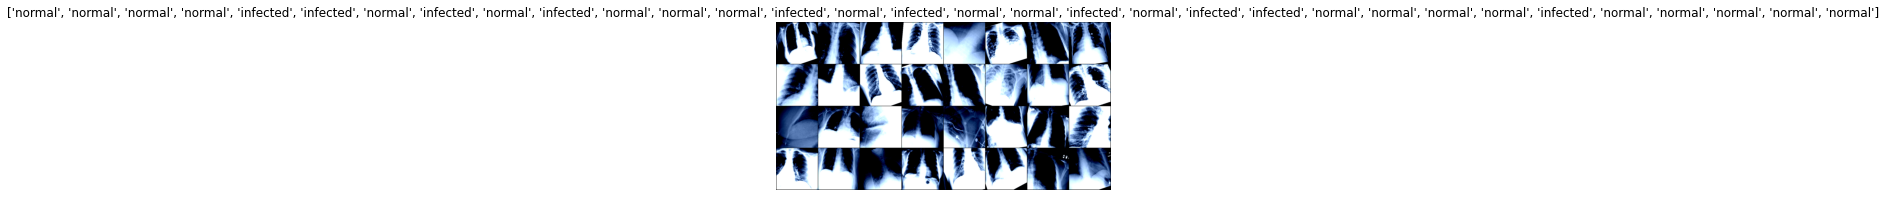

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

# Load Pre-Trained VGG-16 and Resnet-18


In [0]:
resnet18 = models.resnet18(pretrained=True)
#print(resnet18)


In [52]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
#print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

Output Layer of VGG16 :  1000


# Removing and Replacing the Last Layers from VGG-16 and Resnet-18


In [0]:
#print(resnet18.fc)
no_features = resnet18.fc.in_features
#print(no_features)
resnetfeatures = list(resnet18.fc.children())[:0] # Remove last layers

In [54]:
variable = (53*10)+100
resnetfeatures.extend([nn.Linear(no_features, variable)])
resnetfeatures.extend([nn.Linear(variable, len(class_names))])
resnet18.fc = nn.Sequential(*resnetfeatures)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
num_features = vgg16.classifier[0].in_features
vggfeatures = list(vgg16.classifier.children())[:0] # Remove last layers

In [56]:
variable = (53*10)+100
vggfeatures.extend([nn.Linear(num_features, variable)])
vggfeatures.extend([nn.Linear(variable, len(class_names))])
vgg16.classifier = nn.Sequential(*vggfeatures)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Freezing the remaining layers

In [0]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

In [58]:
print(vggfeatures)

[Linear(in_features=25088, out_features=630, bias=True), Linear(in_features=630, out_features=2, bias=True)]


In [0]:
# Freeze training for all layers
for param in resnet18.parameters():
    param.require_grad = False

# Loss Function and Optimizer

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

# Training for VGG-16

In [61]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    torch.save(vgg16.state_dict(), 'vgg16_FC_Only.pth')

print('Finished Training')

Train Epoch: 0 [11968/12000 (100%)]	Loss: 0.052775: : 375it [03:27,  1.81it/s]
Train Epoch: 1 [11968/12000 (100%)]	Loss: 0.330380: : 375it [03:26,  1.81it/s]
Train Epoch: 2 [11968/12000 (100%)]	Loss: 0.103684: : 375it [03:24,  1.83it/s]
Train Epoch: 3 [11968/12000 (100%)]	Loss: 0.259997: : 375it [03:26,  1.82it/s]
Train Epoch: 4 [11968/12000 (100%)]	Loss: 0.202853: : 375it [03:27,  1.81it/s]
Train Epoch: 5 [11968/12000 (100%)]	Loss: 0.038730: : 375it [03:25,  1.83it/s]
Train Epoch: 6 [11968/12000 (100%)]	Loss: 0.347362: : 375it [03:27,  1.80it/s]
Train Epoch: 7 [11968/12000 (100%)]	Loss: 0.121958: : 375it [03:27,  1.81it/s]
Train Epoch: 8 [11968/12000 (100%)]	Loss: 0.142584: : 375it [03:25,  1.82it/s]
Train Epoch: 9 [11968/12000 (100%)]	Loss: 0.384130: : 375it [03:24,  1.83it/s]


Finished Training


# Testing VGG-16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


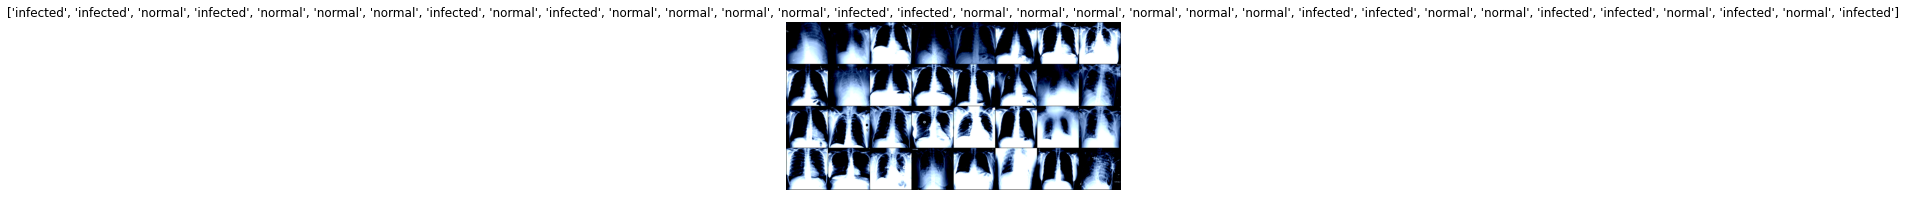

In [62]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [63]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected infected normal infected normal normal normal infected normal infected normal normal normal normal infected infected normal normal normal normal normal normal infected infected normal normal infected infected normal infected normal infected
Ground Truth:  infected infected normal infected normal normal normal infected normal infected normal normal normal normal infected infected normal normal normal normal normal normal infected infected normal normal infected infected normal infected normal infected


In [64]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 97 %


# Confusion Matrix for VGG-16

In [65]:
nb_classes = 2

confusion_matrix_train = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(trainloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16(images)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix_train[t.long(), p.long()] += 1

confusion_matrix_test = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16(images)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix_test[t.long(), p.long()] += 1

confusion_matrix_valid = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(validloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16(images)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix_valid[t.long(), p.long()] += 1

print("Confusion matrix for training\n", confusion_matrix_train)
print("\nConfusion matrix for testing\n", confusion_matrix_test)
print("\nConfusion matrix for training\n", confusion_matrix_valid)

Confusion matrix for training
 tensor([[2315., 1999.],
        [3310., 2876.]])

Confusion matrix for testing
 tensor([[276., 254.],
        [429., 357.]])

Confusion matrix for training
 tensor([[286., 262.],
        [419., 349.]])


# Training for Resnet-18

In [67]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    torch.save(resnet18.state_dict(), 'res18_FC_Only.pth')

print('Finished Training')

Streaming output truncated to the last 5000 lines.
Train Epoch: 2 [5120/12000 (43%)]	Loss: 0.811009: : 161it [01:27,  1.73it/s]
Train Epoch: 2 [5152/12000 (43%)]	Loss: 0.868134: : 161it [01:28,  1.73it/s]
Train Epoch: 2 [5152/12000 (43%)]	Loss: 0.868134: : 162it [01:28,  1.54it/s]
Train Epoch: 2 [5184/12000 (43%)]	Loss: 0.717186: : 162it [01:29,  1.54it/s]
Train Epoch: 2 [5184/12000 (43%)]	Loss: 0.717186: : 163it [01:29,  1.25it/s]
Train Epoch: 2 [5216/12000 (43%)]	Loss: 0.741875: : 163it [01:29,  1.25it/s]
Train Epoch: 2 [5248/12000 (44%)]	Loss: 0.678715: : 163it [01:29,  1.25it/s]
Train Epoch: 2 [5248/12000 (44%)]	Loss: 0.678715: : 165it [01:29,  1.70it/s]
Train Epoch: 2 [5280/12000 (44%)]	Loss: 0.848614: : 165it [01:30,  1.70it/s]
Train Epoch: 2 [5280/12000 (44%)]	Loss: 0.848614: : 166it [01:30,  1.52it/s]
Train Epoch: 2 [5312/12000 (44%)]	Loss: 0.840167: : 166it [01:31,  1.52it/s]
Train Epoch: 2 [5312/12000 (44%)]	Loss: 0.840167: : 167it [01:31,  1.33it/s]
Train Epoch: 2 [5344/1200

Finished Training


# Testing Resnet-18

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


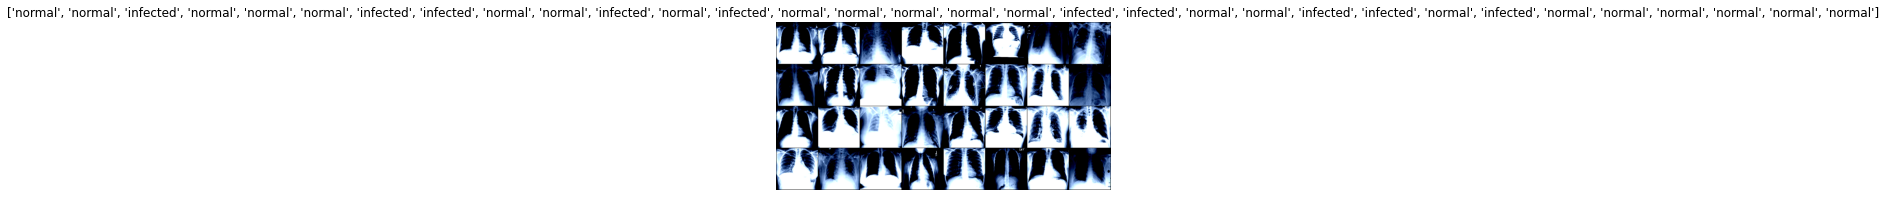

In [68]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [69]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnet18(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected infected infected infected infected normal infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected
Ground Truth:  normal normal infected normal normal normal infected infected normal normal infected normal infected normal normal normal normal normal infected infected normal normal infected infected normal infected normal normal normal normal normal normal


In [70]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 41 %


# Confusion Matrix for Resnet-18

In [71]:
nb_classes = 2

confusion_matrix_train = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(trainloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet18(images)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix_train[t.long(), p.long()] += 1

confusion_matrix_test = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet18(images)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix_test[t.long(), p.long()] += 1

confusion_matrix_valid = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(validloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet18(images)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix_valid[t.long(), p.long()] += 1

print("Confusion matrix for training\n", confusion_matrix_train)
print("\nConfusion matrix for testing\n", confusion_matrix_test)
print("\nConfusion matrix for training\n", confusion_matrix_valid)

Confusion matrix for training
 tensor([[4289.,    0.],
        [6211.,    0.]])

Confusion matrix for testing
 tensor([[548.,   0.],
        [768.,   0.]])

Confusion matrix for training
 tensor([[536.,   0.],
        [780.,   0.]])


# TASK 2

# Unfreezing Entire VGG-16

In [8]:
# Load the pretrained VGG-16 model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [10]:
num_features = vgg16.classifier[0].in_features
vggfeatures = list(vgg16.classifier.children())[:0] # Remove last layers

variable = (53*10)+100
vggfeatures.extend([nn.Linear(num_features, variable)])
vggfeatures.extend([nn.Linear(variable, len(class_names))])
vgg16.classifier = nn.Sequential(*vggfeatures)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

We will not freeze any of the previous layers

# Training VGG-16

In [0]:
Epochs = 8
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.003, momentum=0.9)

In [15]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    torch.save(vgg16.state_dict(), 'vgg16_entire.pth')

print('Finished Training')

Streaming output truncated to the last 5000 lines.
Train Epoch: 1 [4192/12000 (35%)]	Loss: 0.310115: : 132it [01:23,  1.38it/s]
Train Epoch: 1 [4224/12000 (35%)]	Loss: 0.393051: : 132it [01:24,  1.38it/s]
Train Epoch: 1 [4224/12000 (35%)]	Loss: 0.393051: : 133it [01:24,  1.53it/s]
Train Epoch: 1 [4256/12000 (35%)]	Loss: 0.143463: : 133it [01:24,  1.53it/s]
Train Epoch: 1 [4256/12000 (35%)]	Loss: 0.143463: : 134it [01:24,  1.65it/s]
Train Epoch: 1 [4288/12000 (36%)]	Loss: 0.225271: : 134it [01:25,  1.65it/s]
Train Epoch: 1 [4288/12000 (36%)]	Loss: 0.225271: : 135it [01:25,  1.74it/s]
Train Epoch: 1 [4320/12000 (36%)]	Loss: 0.167043: : 135it [01:26,  1.74it/s]
Train Epoch: 1 [4320/12000 (36%)]	Loss: 0.167043: : 136it [01:26,  1.35it/s]
Train Epoch: 1 [4352/12000 (36%)]	Loss: 0.144973: : 136it [01:27,  1.35it/s]
Train Epoch: 1 [4352/12000 (36%)]	Loss: 0.144973: : 137it [01:27,  1.49it/s]
Train Epoch: 1 [4384/12000 (37%)]	Loss: 0.246532: : 137it [01:27,  1.49it/s]
Train Epoch: 1 [4384/1200

Finished Training


# Testing VGG-16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


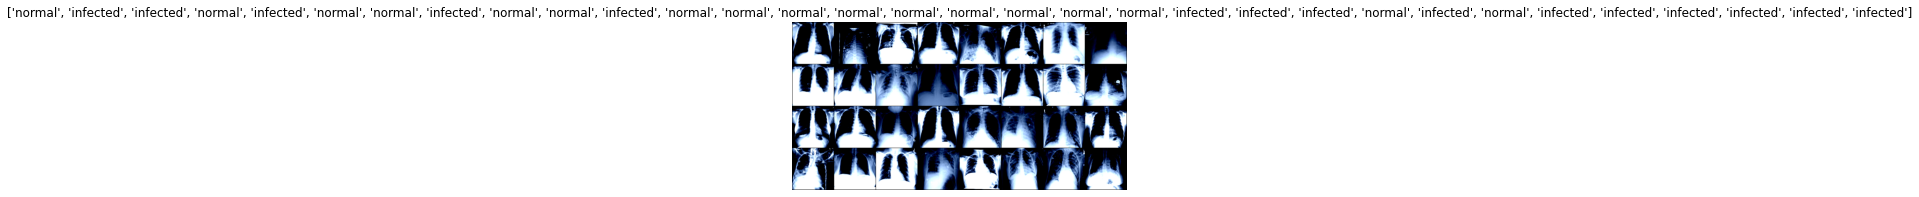

In [18]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [19]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal infected infected normal infected normal normal infected normal normal infected normal normal normal normal normal normal normal normal normal infected infected infected normal infected normal normal infected normal infected infected infected
Ground Truth:  normal infected infected normal infected normal normal infected normal normal infected normal normal normal normal normal normal normal normal normal infected infected infected normal infected normal infected infected infected infected infected infected


In [20]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 96 %


# Confusion Matrix for VGG-16

In [21]:
nb_classes = 2

confusion_matrix_train = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(trainloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16(images)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix_train[t.long(), p.long()] += 1

confusion_matrix_test = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16(images)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix_test[t.long(), p.long()] += 1

confusion_matrix_valid = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(validloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16(images)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix_valid[t.long(), p.long()] += 1

print("Confusion matrix for training\n", confusion_matrix_train)
print("\nConfusion matrix for testing\n", confusion_matrix_test)
print("\nConfusion matrix for training\n", confusion_matrix_valid)

Confusion matrix for training
 tensor([[1719., 2576.],
        [2406., 3799.]])

Confusion matrix for testing
 tensor([[208., 331.],
        [309., 468.]])

Confusion matrix for training
 tensor([[199., 340.],
        [318., 459.]])


# Unfreezing Entire ResNet-18

In [22]:
resnet18 = models.resnet18(pretrained=True)
#print(resnet18)

#print(resnet18.fc)
no_features = resnet18.fc.in_features
#print(no_features)
resnetfeatures = list(resnet18.fc.children())[:0] # Remove last layers


variable = (53*10)+100
resnetfeatures.extend([nn.Linear(no_features, variable)])
resnetfeatures.extend([nn.Linear(variable, len(class_names))])
resnet18.fc = nn.Sequential(*resnetfeatures)
print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

We will not freeze any of the previous layers

# Training ResNet-18

In [0]:
Epochs = 8
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.003, momentum=0.9)

In [24]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    torch.save(resnet18.state_dict(), 'res18_entire.pth')

print('Finished Training')

Streaming output truncated to the last 5000 lines.
Train Epoch: 1 [4160/12000 (35%)]	Loss: 0.837096: : 130it [01:13,  1.64it/s]
Train Epoch: 1 [4160/12000 (35%)]	Loss: 0.837096: : 131it [01:13,  1.43it/s]
Train Epoch: 1 [4192/12000 (35%)]	Loss: 0.869411: : 131it [01:14,  1.43it/s]
Train Epoch: 1 [4192/12000 (35%)]	Loss: 0.869411: : 132it [01:14,  1.90it/s]
Train Epoch: 1 [4224/12000 (35%)]	Loss: 0.865444: : 132it [01:14,  1.90it/s]
Train Epoch: 1 [4224/12000 (35%)]	Loss: 0.865444: : 133it [01:14,  2.43it/s]
Train Epoch: 1 [4256/12000 (35%)]	Loss: 0.800941: : 133it [01:15,  2.43it/s]
Train Epoch: 1 [4256/12000 (35%)]	Loss: 0.800941: : 134it [01:15,  1.65it/s]
Train Epoch: 1 [4288/12000 (36%)]	Loss: 0.718093: : 134it [01:16,  1.65it/s]
Train Epoch: 1 [4288/12000 (36%)]	Loss: 0.718093: : 135it [01:16,  1.45it/s]
Train Epoch: 1 [4320/12000 (36%)]	Loss: 0.845242: : 135it [01:16,  1.45it/s]
Train Epoch: 1 [4320/12000 (36%)]	Loss: 0.845242: : 136it [01:16,  1.93it/s]
Train Epoch: 1 [4352/1200

Finished Training


# Testing Resnet-18

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


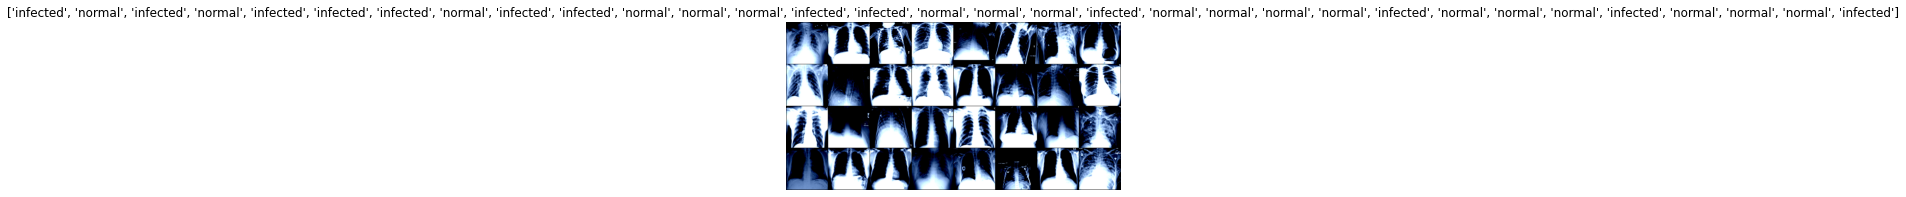

In [25]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [26]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnet18(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected infected
Ground Truth:  infected normal infected normal infected infected infected normal infected infected normal normal normal infected infected normal normal normal infected normal normal normal normal infected normal normal normal infected normal normal normal infected


In [27]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 41 %


# Confusion Matrix for ResNet-18

In [28]:
nb_classes = 2

confusion_matrix_train = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(trainloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet18(images)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix_train[t.long(), p.long()] += 1

confusion_matrix_test = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet18(images)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix_test[t.long(), p.long()] += 1

confusion_matrix_valid = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(validloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet18(images)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix_valid[t.long(), p.long()] += 1

print("Confusion matrix for training\n", confusion_matrix_train)
print("\nConfusion matrix for testing\n", confusion_matrix_test)
print("\nConfusion matrix for training\n", confusion_matrix_valid)

Confusion matrix for training
 tensor([[4289.,    0.],
        [6211.,    0.]])

Confusion matrix for testing
 tensor([[541.,   0.],
        [775.,   0.]])

Confusion matrix for training
 tensor([[538.,   0.],
        [778.,   0.]])
